In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(55000)
from sklearn import model_selection
import random
import os
from tqdm import tqdm
print(tf.__version__)

2.0.0-alpha0


## Image preprocessing
### Example on one image

[[169 174 180 ... 213 210 205]
 [169 174 180 ... 215 212 207]
 [169 175 179 ... 217 214 210]
 ...
 [128 132 134 ...   3   3   2]
 [126 128 131 ...   3   3   2]
 [124 128 131 ...   2   2   2]]


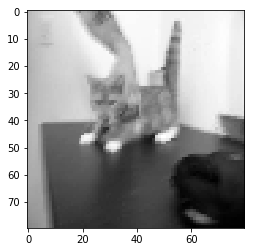

In [17]:
path = './train/'
img_name = 'cat.0.jpg'
img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
new_img_array = cv2.resize(img_array, dsize=(80, 80))
print(new_img_array)
plt.imshow(new_img_array,cmap="gray")

We can extract the label directly from the image name as follows: 

In [23]:
img_name.split('.')[0]

'cat'

## Same for all images to create `X` and `y`

In [39]:
X = []
y = []

path = './train/'

for img_name in tqdm(os.listdir(path)):

    label = int(img_name.split('.')[0]=='cat') # 1 if cat, 0 if dog
    img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))

    X.append(new_img_array)
    y.append(label)

# Turn lists into np.arrays
X = np.array(X)
y = np.array(y)

# Save as .npy files
np.save('x', X)
np.save('y', y)

100%|██████████| 25000/25000 [01:14<00:00, 337.15it/s]


Load `X` and `y`

In [2]:
X = np.load('x.npy')
y = np.load('y.npy')

## Create a train and test dataset

In [8]:
X = X/255 # normalisation
X = X.reshape(-1, 80, 80, 1) # Reshape `X` for adding number of channels (here 1 as we have black and white pictures).
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17500, 80, 80, 1) (17500,)
(7500, 80, 80, 1) (7500,)


## Create a model

In [14]:
n_input = X.shape[1:]
n_classes = 1 # binary classification (cat or not cat)
n_input

(80, 80, 1)

In [20]:
checkpoint_path = "./checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True, period=5) # Save weights, every 1 epoch

In [15]:
def make_model(n_input, n_classes, n_layers, do_rate=0.5, optimizer='adam'):

    # Initialise sequential model
    model = tf.keras.Sequential()
    
    # Create the convolutional base
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = n_input))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
    
    # Flattening layer
    model.add(tf.keras.layers.Flatten())

    # First layer
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5000)))
    model.add(tf.keras.layers.Dropout(rate=do_rate))

    # Add layers
    for i in range(n_layers-1):
        model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5000)))
        model.add(tf.keras.layers.Dropout(rate=do_rate))

    # Add closing layer
    model.add(tf.keras.layers.Dense(n_classes, activation='sigmoid'))

    # Compile 
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [16]:
model_1 = make_model(n_input, n_classes, n_layers=1, do_rate=0.4, optimizer='adam')
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                331808    
_________________________________________________________________
dropout (Dropout)            (None, 32)               

In [142]:
training_epochs = 10
history = model_1.fit(X_train, y_train, 
                      epochs=training_epochs,
                      validation_data=(X_test, y_test),
                      callbacks = [cp_callback], verbose=2)

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 - 166s - loss: 0.6279 - accuracy: 0.6488 - val_loss: 0.5527 - val_accuracy: 0.7199
Epoch 2/10
17500/17500 - 163s - loss: 0.5427 - accuracy: 0.7342 - val_loss: 0.5073 - val_accuracy: 0.7655
Epoch 3/10
17500/17500 - 162s - loss: 0.4901 - accuracy: 0.7671 - val_loss: 0.4770 - val_accuracy: 0.7747
Epoch 4/10
17500/17500 - 167s - loss: 0.4514 - accuracy: 0.7898 - val_loss: 0.4569 - val_accuracy: 0.7821
Epoch 5/10

Epoch 00005: saving model to ./checkpoints/cp-0005.ckpt
17500/17500 - 163s - loss: 0.4141 - accuracy: 0.8109 - val_loss: 0.4425 - val_accuracy: 0.7932
Epoch 6/10
17500/17500 - 177s - loss: 0.3791 - accuracy: 0.8298 - val_loss: 0.4561 - val_accuracy: 0.7847
Epoch 7/10
17500/17500 - 153s - loss: 0.3483 - accuracy: 0.8439 - val_loss: 0.5135 - val_accuracy: 0.7783
Epoch 8/10
17500/17500 - 133s - loss: 0.3168 - accuracy: 0.8622 - val_loss: 0.4829 - val_accuracy: 0.7848
Epoch 9/10
17500/17500 - 129s - loss: 0.2815 -

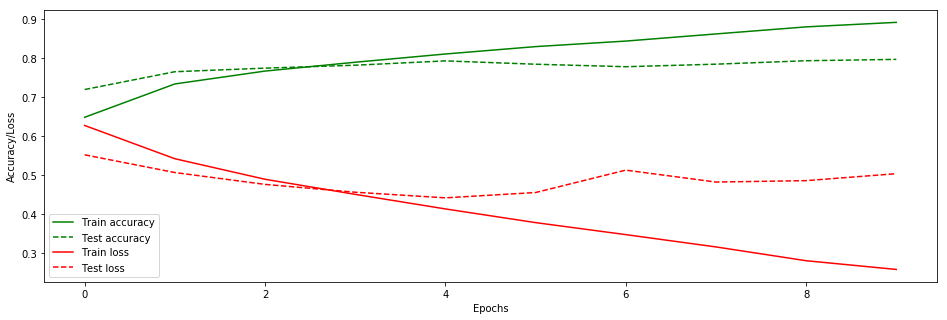

In [154]:
plt.figure(figsize=(16,5))
plt.plot(history.epoch, history.history['accuracy'], 'g-', label='Train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], 'g--' , label='Test accuracy')
plt.plot(history.epoch, history.history['loss'], 'r-', label='Train loss')
plt.plot(history.epoch, history.history['val_loss'], 'r--' , label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend();

## Save the model

In [144]:
model_1.save('./checkpoints/small_model.h5')

## Load the model

In [26]:
model_1 = tf.keras.models.load_model('./checkpoints/small_model.h5')

## Evaluate the model on my own cats

In [24]:
def preprocess_images(path):
    X = []

    for img_name in tqdm(os.listdir(path)):

        img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))

        X.append(new_img_array)

    # Turn lists into np.arrays
    X = np.array(X)

    return X

In [25]:
X_katoen = preprocess_images('./katoen/')
print(X_katoen.shape)

100%|██████████| 16/16 [00:00<00:00, 109.94it/s]


(16, 80, 80)


In [27]:
X_katoen_test = X_katoen/255
X_katoen_test = X_katoen_test.reshape(-1, 80, 80, 1)
model_1.evaluate(X_katoen_test, np.ones(16))

16/16 [==============================] - 0s 6ms/sample - loss: 1.1926 - accuracy: 0.5625


[1.1925630569458008, 0.5625]

56% accuracy is not good... but the pictures were also quite challenging:

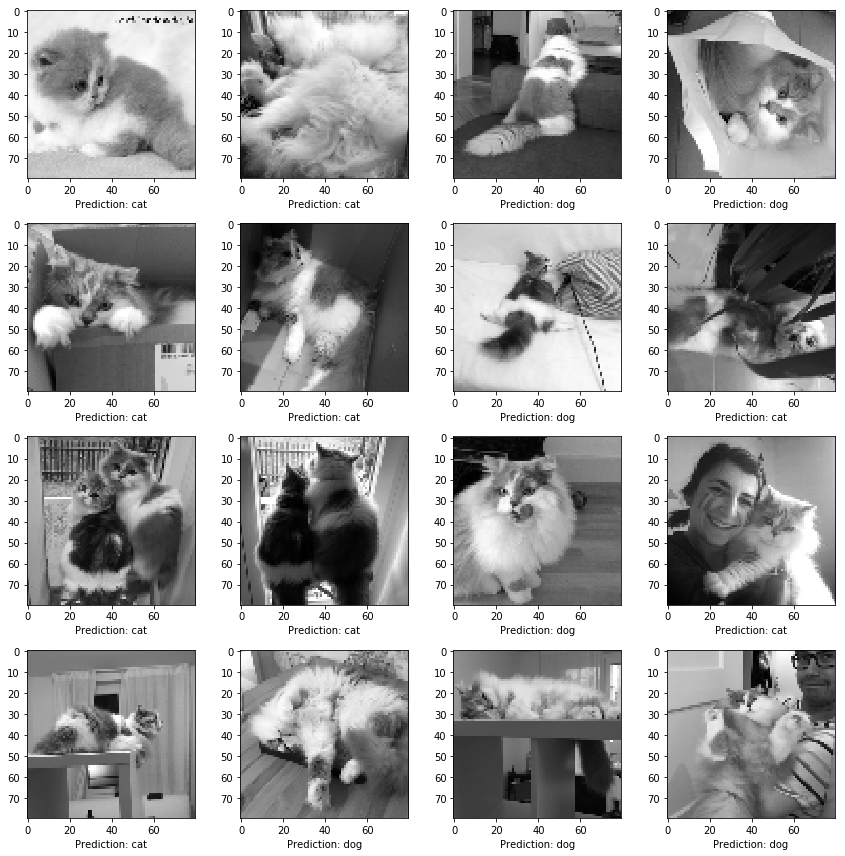

In [152]:
plt.figure(figsize=(12, 12))
for index, img in enumerate(X_katoen):
    X = img/255 # normalisation
    X = X.reshape(1, 80, 80, 1) # Reshape `X` for adding number of channels (here 1 as we have black and white pictures).
    prediction = 'cat' if (float(model_1.predict(X))>0.5) else 'dog'
    plt.subplot(4, 4, index+1)
    plt.imshow(img, cmap="gray")
    plt.xlabel(f'Prediction: {prediction}')
plt.tight_layout()

## Improve model
### Grid search and regularisation

Our previous model is overfitting after only 3 epochs. We will try to reduce overfitting by trying different models and including early stopping to make sure that training stops after 2 epochs with no decrease in val_loss of at least 0.002.

In [50]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=2, min_delta=0.002)

In [18]:
training_epochs = 10
n_input = X.shape[1:]
n_classes = 1 # binary classification (cat or not cat)
nb_layers = [1, 2]
do_rates = [0.4, 0.5, 0.6]

In [21]:
models = []
model_nb = 0

for do_rate in do_rates:
    for layer in nb_layers:
        
        # Create model
        model = make_model(n_input, n_classes, n_layers=layer, do_rate=do_rate, optimizer='adam')
        
        # Fit model
        history = model.fit(X_train, y_train, epochs=training_epochs, validation_data=(X_test, y_test), 
                    callbacks = [cp_callback, earlystop], verbose=2)

        # Save model
        model_nb += 1
        model.save(f'./checkpoints/model_{model_nb}.h5')        

        # Store results
        models.append({
            'model_nb': model_nb,
            'do_rate': do_rate,
            'nb_layers': layer,
            'epochs': history.epoch,
            'train_acc': history.history['accuracy'],
            'train_loss': history.history['loss'],
            'test_acc': history.history['val_accuracy'],
            'test_loss': history.history['val_loss']})

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 - 131s - loss: 0.6624 - accuracy: 0.5966 - val_loss: 0.5907 - val_accuracy: 0.6987
Epoch 2/10
17500/17500 - 120s - loss: 0.5699 - accuracy: 0.7065 - val_loss: 0.5065 - val_accuracy: 0.7540
Epoch 3/10
17500/17500 - 123s - loss: 0.5081 - accuracy: 0.7524 - val_loss: 0.4961 - val_accuracy: 0.7664
Epoch 4/10
17500/17500 - 116s - loss: 0.4633 - accuracy: 0.7858 - val_loss: 0.4555 - val_accuracy: 0.7881
Epoch 5/10

Epoch 00005: saving model to ./checkpoints/cp-0005.ckpt
17500/17500 - 118s - loss: 0.4346 - accuracy: 0.7957 - val_loss: 0.4534 - val_accuracy: 0.7864
Epoch 6/10
17500/17500 - 118s - loss: 0.4078 - accuracy: 0.8147 - val_loss: 0.4692 - val_accuracy: 0.7881
Epoch 7/10
17500/17500 - 116s - loss: 0.3786 - accuracy: 0.8301 - val_loss: 0.4575 - val_accuracy: 0.7953
Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 - 115s - loss: 0.6808 - accuracy: 0.5540 - val_loss: 0.6421 - val_accuracy: 0.64

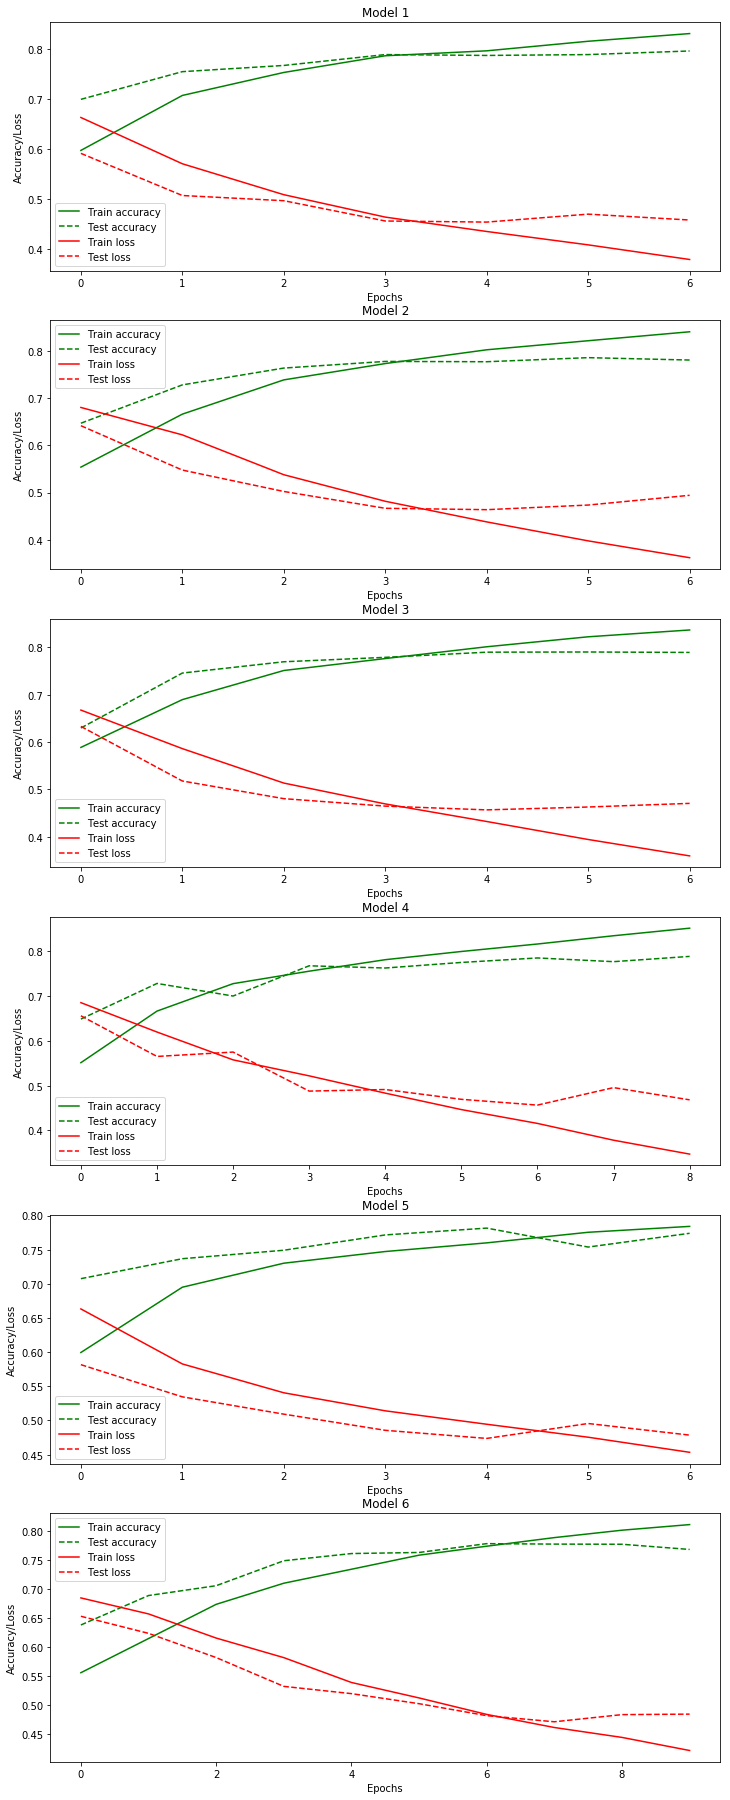

In [22]:
fig, axs = plt.subplots(len(models), 1, figsize=(12, 32))

for i, ax in enumerate(axs):
    
    model = models[i] # dictionary for model
    
    ax.plot(model['epochs'], model['train_acc'], 'g-', label='Train accuracy')
    ax.plot(model['epochs'], model['test_acc'], 'g--' , label='Test accuracy')
    ax.plot(model['epochs'], model['train_loss'], 'r-', label='Train loss')
    ax.plot(model['epochs'], model['test_loss'], 'r--' , label='Test loss')
    
    ax.set_title(f'Model {i+1}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy/Loss')
    ax.legend();

Visually model 5 is the best, let's see if it does better on the photos of my own cats!

### Evaluation of the model

#### On pictures of my own cats

In [32]:
model_best = tf.keras.models.load_model('./checkpoints/model_5.h5')
model_best.evaluate(X_katoen_test, np.ones(16))

16/16 [==============================] - 0s 7ms/sample - loss: 0.9279 - accuracy: 0.3750


[0.9279099106788635, 0.375]

The model did not improve at all and can still not catch cats in unusual positions. This must be because the pictures in the training set display more traditional pictures of cats!

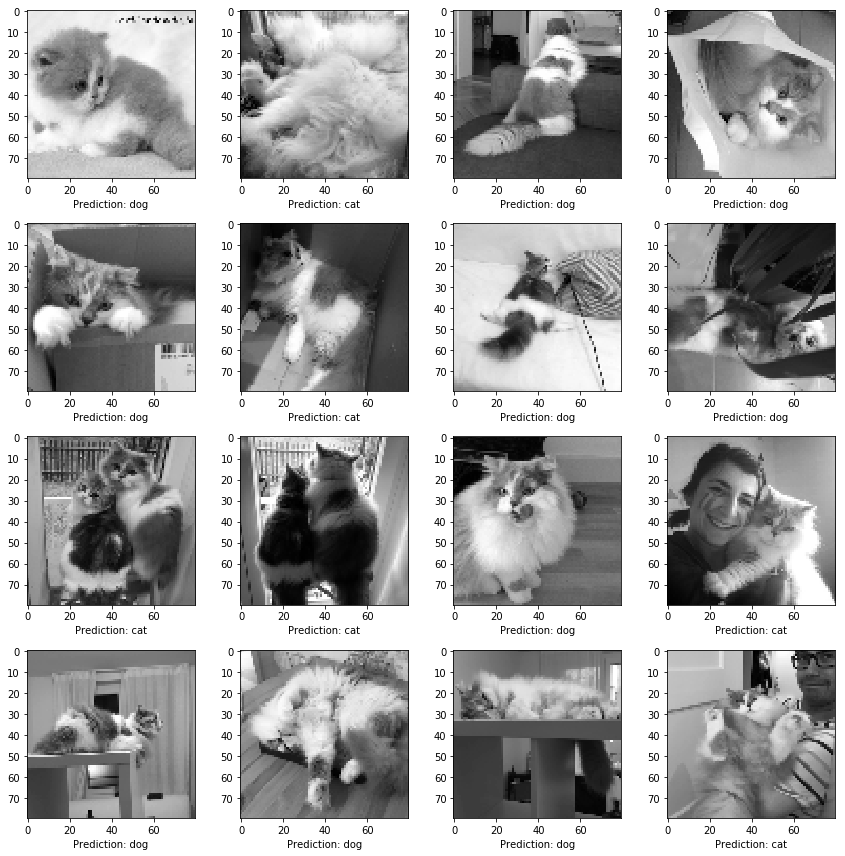

In [33]:
plt.figure(figsize=(12, 12))
for index, img in enumerate(X_katoen):
    X = img/255 # normalisation
    X = X.reshape(1, 80, 80, 1) # Reshape `X` for adding number of channels (here 1 as we have black and white pictures).
    prediction = 'cat' if (float(model_best.predict(X))>0.5) else 'dog'
    plt.subplot(4, 4, index+1)
    plt.imshow(img, cmap="gray")
    plt.xlabel(f'Prediction: {prediction}')
plt.tight_layout()

#### On other unseen pictures

In [45]:
X_unseen = preprocess_images('./test/')
print(X_unseen.shape)

100%|██████████| 12500/12500 [00:21<00:00, 585.82it/s]


(12500, 80, 80)


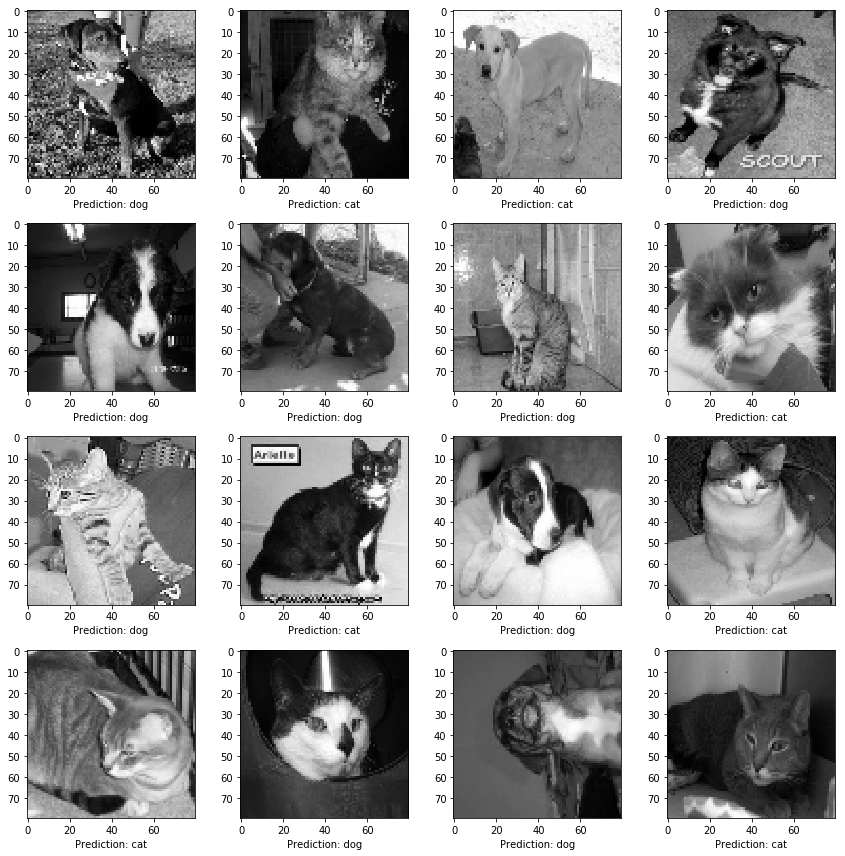

In [46]:
X_unseen_16 = X_unseen[random.sample(range(12500),16)]

plt.figure(figsize=(12, 12))

for index, img in enumerate(X_unseen_16):
    X = img/255 # normalisation
    X = X.reshape(1, 80, 80, 1) # Reshape `X` for adding number of channels (here 1 as we have black and white pictures).
    prediction = 'cat' if (float(model_best.predict(X))>0.5) else 'dog'
    plt.subplot(4, 4, index+1)
    plt.imshow(img, cmap="gray")
    plt.xlabel(f'Prediction: {prediction}')
plt.tight_layout()

## Using transfer learning
### Preprocessing

In [2]:
def preprocess_images_color(path, dim):
    X = []
    y = []
    
    for img_name in tqdm(os.listdir(path)):

        label = int(img_name.split('.')[0]=='cat') # 1 if cat, 0 if dog
        img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_COLOR)
        new_img_array = cv2.resize(img_array, dsize=(dim, dim))

        X.append(new_img_array)
        y.append(label)

    # Turn lists into np.arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [ ]:
path = './train/' 
dim = 128
X_col, y_col = preprocess_images_color(path, dim)

# Save as .npy files
np.save('x_col', X_col)
np.save('y_col', y_col)

In [4]:
X_col = np.load('x_col.npy')
y_col = np.load('y_col.npy')

### Create a train and test dataset

In [5]:
sample_idx = random.sample(range(25000), 2000)
X_col = X_col[sample_idx]
y_col = y_col[sample_idx]
X_col = X_col/255 # normalisation
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_col, y_col, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1600, 128, 128, 3) (1600,)
(400, 128, 128, 3) (400,)


### Create a model

In [6]:
path = './train/' 
dim = 128
n_input = X_train.shape[1:]
n_classes = 1 # binary classification (cat or not cat)
n_input

(128, 128, 3)

In [7]:
from tensorflow.keras.applications import MobileNet
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(dim,dim,3))

In [12]:
def make_model_transfer_learning(n_input, n_classes, n_layers, do_rate=0.5, optimizer='adam'):

    # Initialise sequential model
    model = tf.keras.Sequential()
    
    # Add the pre-trained convolutional base
    model.add(conv_base)
    
    # Flattening layer
    model.add(tf.keras.layers.Flatten())

    # First layer
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5000)))
    model.add(tf.keras.layers.Dropout(rate=do_rate))

    # Add layers
    for i in range(n_layers-1):
        model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5000)))
        model.add(tf.keras.layers.Dropout(rate=do_rate))

    # Add closing layer
    model.add(tf.keras.layers.Dense(n_classes, activation='sigmoid'))

    # Compile 
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [13]:
model_1_col = make_model_transfer_learning(n_input, n_classes, n_layers=1, do_rate=0.60, optimizer='adam')
model_1_col.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                524320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,753,217
Trainable params: 3,731,329
Non-trainable params: 21,888
_________________________________________________________________


In [11]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=2, min_delta=0.002)
training_epochs = 3
history = model_1_col.fit(X_train, y_train,
                          epochs=training_epochs,
                          validation_data=(X_test, y_test),
                          callbacks = [earlystop],
                          verbose=2)

Train on 1600 samples, validate on 400 samples
Epoch 1/3
1600/1600 - 395s - loss: 7.4654 - accuracy: 0.5131 - val_loss: 7.2833 - val_accuracy: 0.5250
Epoch 2/3
1600/1600 - 391s - loss: 7.4654 - accuracy: 0.5131 - val_loss: 7.2833 - val_accuracy: 0.5250
Epoch 3/3
1600/1600 - 402s - loss: 7.4654 - accuracy: 0.5131 - val_loss: 7.2833 - val_accuracy: 0.5250


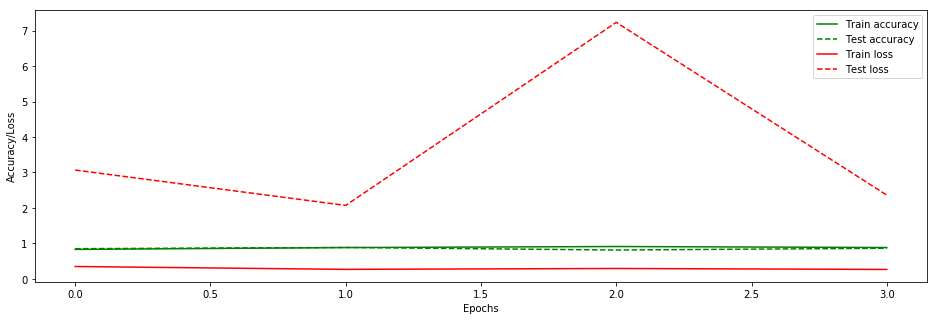

In [52]:
plt.figure(figsize=(16,5))
plt.plot(history.epoch, history.history['accuracy'], 'g-', label='Train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], 'g--' , label='Test accuracy')
plt.plot(history.epoch, history.history['loss'], 'r-', label='Train loss')
plt.plot(history.epoch, history.history['val_loss'], 'r--' , label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend();

### Save the model

In [53]:
model_1_col.save('./checkpoints/model_2_col.h5')

### Evaluation of the model

#### On pictures of my own cats

In [54]:
path = './katoen/' 
dim = 128

X_katoen_col, _ = preprocess_images_color(path, dim)

100%|██████████| 16/16 [00:00<00:00, 82.38it/s]


In [55]:
X_katoen_test = X_katoen_col/255
model_1_col.evaluate(X_katoen_test, np.ones(16))

16/16 [==============================] - 0s 17ms/sample - loss: 3.0972 - accuracy: 0.6875


[3.09723162651062, 0.6875]

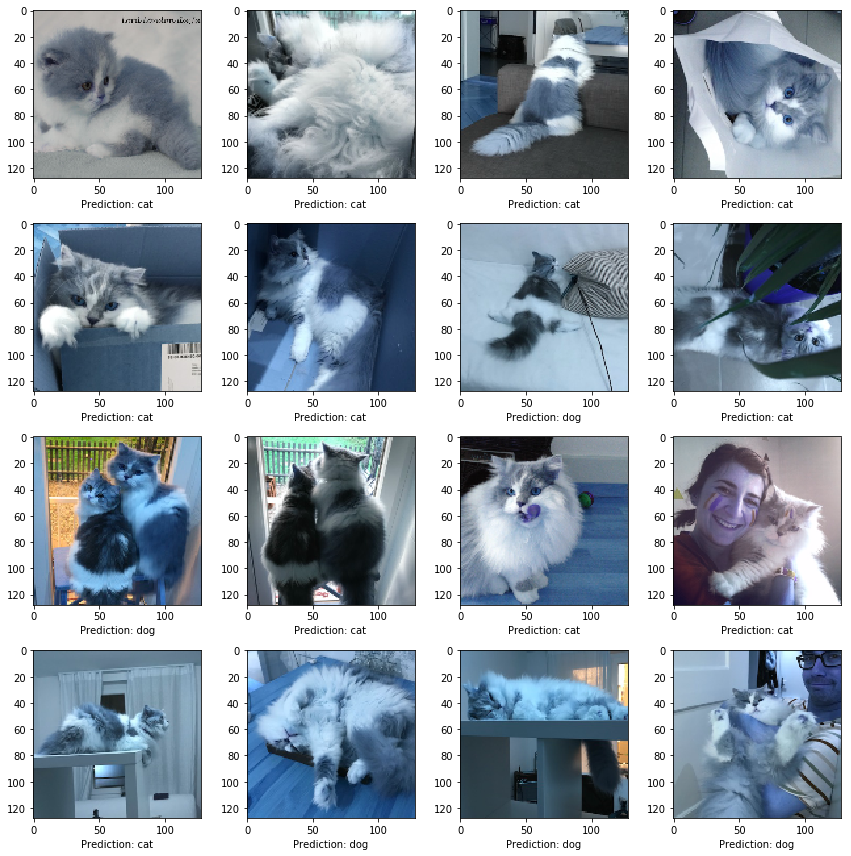

In [56]:
plt.figure(figsize=(12, 12))
for index, img in enumerate(X_katoen_col):
    X = img/255 # normalisation
    X = X.reshape(1, 128, 128, 3) # Reshape `X` for adding number of channels (here 1 as we have black and white pictures).
    prediction = 'cat' if (float(model_1_col.predict(X))>0.5) else 'dog'
    plt.subplot(4, 4, index+1)
    plt.imshow(img)
    plt.xlabel(f'Prediction: {prediction}')
plt.tight_layout()

#### On other unseen data

In [68]:
path = './test/' 
dim = 128
X_unseen_col, _ = preprocess_images_color(path, dim)

100%|██████████| 12500/12500 [00:51<00:00, 241.08it/s]


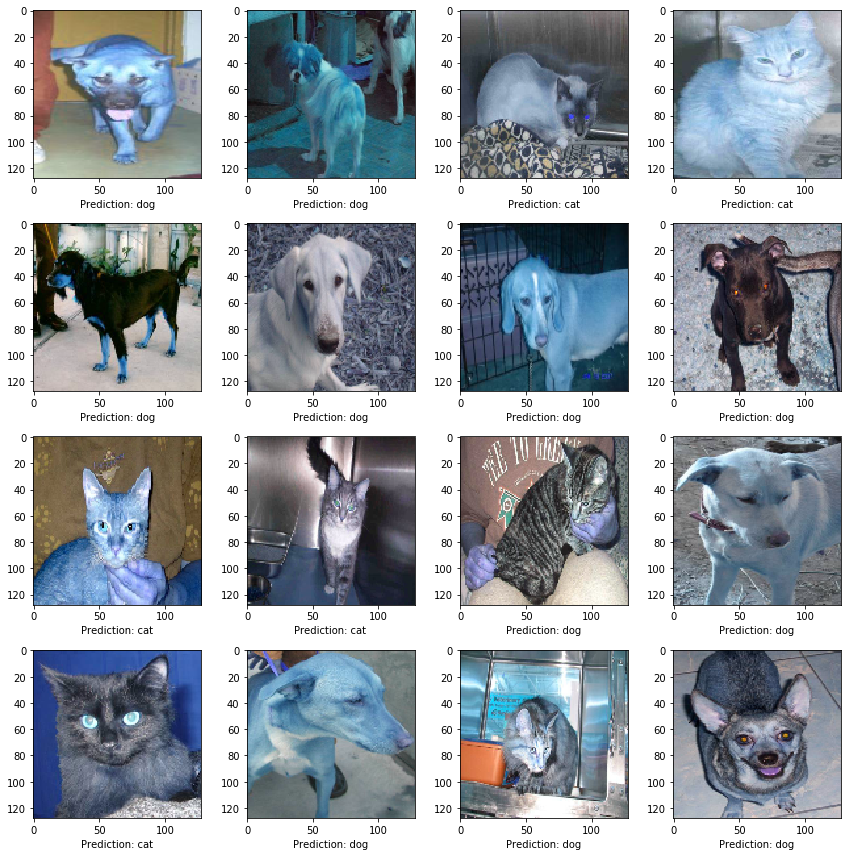

In [69]:
X_unseen_col_16 = X_unseen_col[random.sample(range(12500),16)]

plt.figure(figsize=(12,12))
for index, img in enumerate(X_unseen_col_16):
    X = img/255 # normalisation
    X = X.reshape(1, 128, 128, 3) # Reshape `X` for adding number of channels (here 1 as we have black and white pictures).
    prediction = 'cat' if (float(model_1_col.predict(X))>0.5) else 'dog'
    plt.subplot(4, 4, index+1)
    plt.imshow(img)
    plt.xlabel(f'Prediction: {prediction}')
plt.tight_layout()

Only two cats misqualified as dogs! 